
# **GPytorch Sparse Gaussian Processes Tutorial**



The first step will be to investigate the computational cost of exact GP regression. For that, we will consider a simple toy problem and will record training time, for increasing number of data instances.


In [114]:
!pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [115]:
import math
import torch
import gpytorch
import numpy as np
from torch.nn import Parameter
from matplotlib import pyplot as plt

# We use double precision

torch.set_default_tensor_type(torch.DoubleTensor)

We define the model we will be using. A exact GP for regression.


In [116]:
# We create a class called ExactGPModel that inheritates from ExactGP and sets custom
# mean and covariance functions.

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):

        # We call the superclass with the training data and the associated likelihood.

        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        # We consdier a constant mean equal to zero, which the typical case.

        self.mean_module = gpytorch.means.ZeroMean()

        # We consider a squared exponential (RBF) kernel with an amplitude (scale) parameter.

        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):

        # The forwward method simply computes the prior means and covariances of the
        # process values associated to the input data.

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # We return a multivariate Gaussian distribution with teh corresponding mean
        # and covariances.

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

We now create the training data that we will be using.

In [117]:
N = 1000

# Training data are N points regularly spaced in the interval [0,1].

train_x = torch.linspace(0, 1, N)

# True function is sin(2*pi*x) with additive Gaussian noise with variance 0.04.

train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

We plot the generated data for visualization.

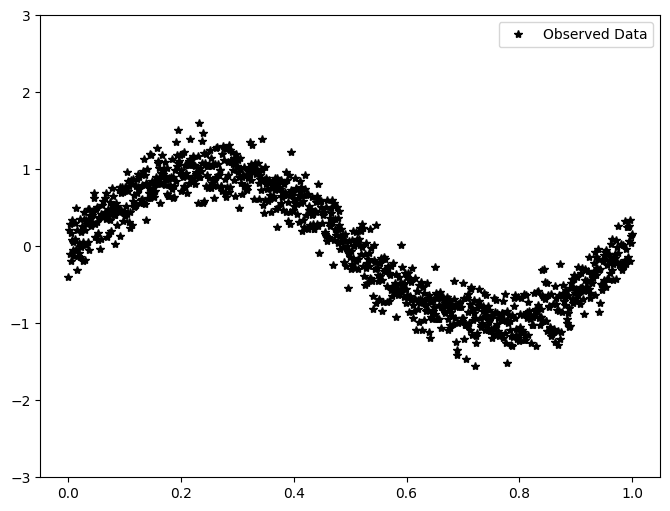

In [118]:
# Initialize plot

f, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot training data as black stars

ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data'])

### **Creaing the Model and Training**

We train the GP using the L-BFGS method.

In [119]:
import time

model = ExactGPModel(train_x, train_y, likelihood)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train_model(model, mll, train_x, train_y, training_iter = 10, likelihood = None):

  model.train()
  losses = torch.zeros(training_iter)

  # We check if we have to optimize the likelihood too or it is already in the
  # model

  if likelihood is None:
    params = model.parameters()
  else:
    params = list(model.parameters()) + list(likelihood.parameters())

  # We instantiate the LBFGS optimizer, which will optimize the hyper-parameters.

  optimizer = torch.optim.LBFGS(params, \
      history_size=10, max_iter=4, line_search_fn="strong_wolfe")

  def closure():
      optimizer.zero_grad()
      output = model(train_x)
      loss = -mll(output, train_y)
      loss.backward()
      return loss

  for i in range(training_iter):

    loss = -mll(model(train_x), train_y) * train_x.shape[ 0 ]
    print('Iter %d/%d - Loss: %f' % (i + 1, training_iter, loss.item()))
    losses[ i ] = torch.from_numpy(np.array([loss.item()]))

    optimizer.step(closure)

  return losses

start = time.time()
result = train_model(model, mll, train_x, train_y)
end = time.time()

print("Total training time:", end - start)

Iter 1/10 - Loss: 212.469570
Iter 2/10 - Loss: -145.007306
Iter 3/10 - Loss: -145.218282
Iter 4/10 - Loss: -144.488512
Iter 5/10 - Loss: -137.272326
Iter 6/10 - Loss: -150.658719
Iter 7/10 - Loss: -147.190364
Iter 8/10 - Loss: -144.236570
Iter 9/10 - Loss: -142.054646
Iter 10/10 - Loss: -147.621917
Total training time: 8.2115159034729


## **Task 1**

Try changing the number of training instances N to larger, and larger values. Write down the training time observed for each value of N. You should see a cubic training cost. That is, 2 times larger N results in 8 times larger training time. Start with N = 100 and finish with N = 4000. Double the value of N each time. Use local execution, if possible, for more reliable results. You should observe that for a few thousand data instances, the training  times start to be too large and hence, using exact GPs for regression is only possible in fairly small datasets.


For the next tasks, we will consider N = 1000 points in the previous problem.

In [120]:
N = 1000

# Training data are N points regularly spaced in the interval [0,1].

train_x = torch.linspace(0, 1, N)

# True function is sin(2*pi*x) with additive Gaussian noise with variance 0.04.

train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

## **Sparse GPs via Nyström Approximation**

Nyström's approximation of the covariance matrix to speed-up the computations of GPs is not directly implemented in GPytorch. However, it is very easy to extend the model to consider it. With this goal, we create a specific covariance function that will do the computations as indicated in the Nyström approximation.



In [121]:
# Custom covairance function to implement the Nyström approximation.
# This covariance function is equal to InducingPointKernel, but without
# adding extra regularization terms (Eq. 9 of Titsias 2009) to the MLL.

class NystromKernel(gpytorch.kernels.InducingPointKernel):
    def forward(self, x1, x2, diag=False, **kwargs):
      covar = self._get_covariance(x1, x2)

      if self.training:
        if not torch.equal(x1, x2):
                raise RuntimeError("x1 should equal x2 in training mode")

      if diag:
        return covar.diagonal(dim1=-1, dim2=-2)
      else:
        return covar

The previous kernel implementes the Nyström approximation to the covariances. Recall from what we have seen in the lectures that it is:
$$\Sigma = \Sigma_{N,M}\Sigma_{M,M}^{-1}\Sigma_{N,M}$$
Now, we can define our model. A standard GP using that particular covariance function.

In [122]:
# We define our approximate GP method based on the Nyström approximation

class NystromSparseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, random_points, likelihood):

        # We call the superclass with the training data and the associated likelihood.

        super(NystromSparseGPModel, self).__init__(train_x, train_y, likelihood)

        # We consdier a constant mean equal to zero, which the typical case.

        self.mean_module = gpytorch.means.ZeroMean()

        # We consider a squared exponential (RBF) kernel with an amplitude (scale) parameter.
        # We use the kernel InducingPointKernel provided in Gpytorch. This kernel will compute
        # approximate covariances as in the Nystrom approximation.

        self.random_points = random_points
        self.covar_module = NystromKernel(\
              gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()), \
              random_points, likelihood)

        # We make the inducing points be constant and prevent their optimization.

        self.covar_module.inducing_points.requires_grad = False

        # We specify that we do not want to add the diagonal correction of FITC

        # By default, GPytorch implements the FITC approximation for sparse GP
        # when using the kernel "InducingPointKernel". However, that kernel is
        # very closely related to the one used in the Nyström approximation.
        # One simply has to remove the extra diagonal term that is added to
        # the diagonal. This is achieved by the previous defined kernel.

    def forward(self, x):

        # We do not add the diagonal correction of the FITC approximation

        gpytorch.settings.sgpr_diagonal_correction(False)

        # The forwward method simply computes the prior means and covariances of the
        # process values associated to the input data.

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # We return a multivariate Gaussian distribution with the corresponding mean
        # and covariances.

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

That is it! We are now ready to use the previos object for regression with a faster computational cost than the exact GP method. We test it on the previous dataset.



In [123]:
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

# We randomly choose M points from the training data

M = 100
random_points = train_x[ torch.randperm(N)[1:M]]

model = NystromSparseGPModel(train_x, train_y, random_points, likelihood)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

start = time.time()
result = train_model(model, mll, train_x, train_y)
end = time.time()

print("Total training time:", end - start)

Iter 1/10 - Loss: 205.876877


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Iter 2/10 - Loss: -170.046629
Iter 3/10 - Loss: -170.488429
Iter 4/10 - Loss: -170.517752
Iter 5/10 - Loss: -170.555946
Iter 6/10 - Loss: -170.586175
Iter 7/10 - Loss: -170.614643
Iter 8/10 - Loss: -170.614643
Iter 9/10 - Loss: -170.614643
Iter 10/10 - Loss: -170.614643
Total training time: 1.3605821132659912


The training time of the previous method should be much faster for M << N and large N.

## **Task 2**

For fixed M, e.g., M = 100. Try changing the number of training instances of the previous problem, N, to larger, and larger values. Write down the training time observed for each value of N. You should see a linear training cost. That is, 2 times larger N results in 2 times larger training time. Start with N = 1000 and finish with N = 40000. Double the value of N each time. Use local execution, if possible, for more reliable results.

### **Predictive Distribution Visualization**

We use the dataset of Ed Snelson for the FITC approximation to check how the approximate predictive distribution looks like and how it compares to the exact one of the full GP.

In [124]:
# We load Ed Snelson's dataset.

import requests
import io

response = requests.get('http://arantxa.ii.uam.es/~dhernan/MLAS2023/EdSnelson.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content))
x_train_snelson = torch.from_numpy(data[ 0 ]).double()
y_train_snelson = torch.from_numpy(data[ 1 ]).double()

We train the exact GP model.

In [125]:

likelihood_exact = gpytorch.likelihoods.GaussianLikelihood()
likelihood_exact.noise = 0.1
model_exact = ExactGPModel(x_train_snelson, y_train_snelson, likelihood)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_exact, model_exact)
result = train_model(model_exact, mll, x_train_snelson, y_train_snelson)


Iter 1/10 - Loss: 59.427757
Iter 2/10 - Loss: 58.167591
Iter 3/10 - Loss: 58.158871
Iter 4/10 - Loss: 58.158865
Iter 5/10 - Loss: 58.158865
Iter 6/10 - Loss: 58.158865
Iter 7/10 - Loss: 58.158865
Iter 8/10 - Loss: 58.158865
Iter 9/10 - Loss: 58.158865
Iter 10/10 - Loss: 58.158865


After training, we plot the predictive distribution.

<Axes: >

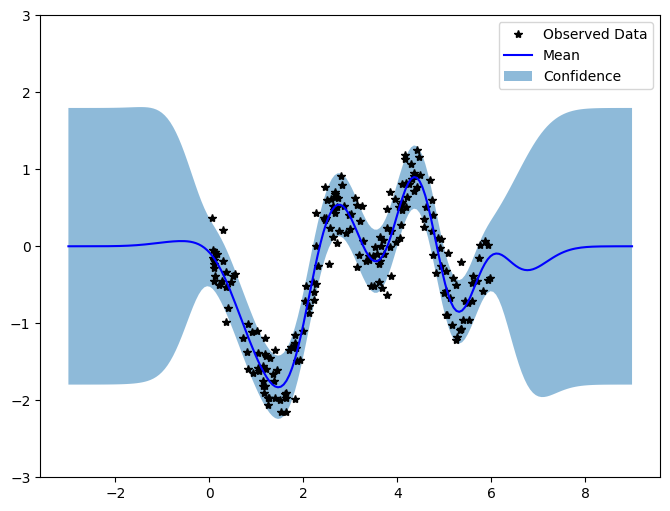

In [126]:
# Get into evaluation (predictive posterior) mode.

def plot_pred_dist_model(model, likelihood):

  model.eval()
  likelihood.eval()

  # Test points are regularly spaced along [-2, 8].
  # Make predictions for y by feeding model through likelihood.

  with torch.no_grad():
      test_x = torch.linspace(-3, 9, 200)
      predictions = likelihood(model(test_x))

  # We plot the predictive distribution (mean +- standard deviation).

  f, ax = plt.subplots(1, 1, figsize=(8, 6))
  lower, upper = predictions.confidence_region()
  ax.plot(x_train_snelson.numpy(), y_train_snelson.numpy(), 'k*')
  ax.plot(test_x.numpy(), predictions.mean.numpy(), 'b')
  ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
  ax.set_ylim([-3, 3])
  ax.legend(['Observed Data', 'Mean', 'Confidence'])
  return ax

plot_pred_dist_model(model_exact, model_exact.likelihood)


We now repeat this process for the approximate GP based on the Nyström approximation. In this case, depending on the randomly chosen points, you should see diverse results.

Iter 1/10 - Loss: 80.886459
Iter 2/10 - Loss: 77.085831
Iter 3/10 - Loss: 66.724128
Iter 4/10 - Loss: 64.707398
Iter 5/10 - Loss: 64.656522
Iter 6/10 - Loss: 64.656517
Iter 7/10 - Loss: 64.656517
Iter 8/10 - Loss: 64.656517
Iter 9/10 - Loss: 64.656517
Iter 10/10 - Loss: 64.656517


<Axes: >

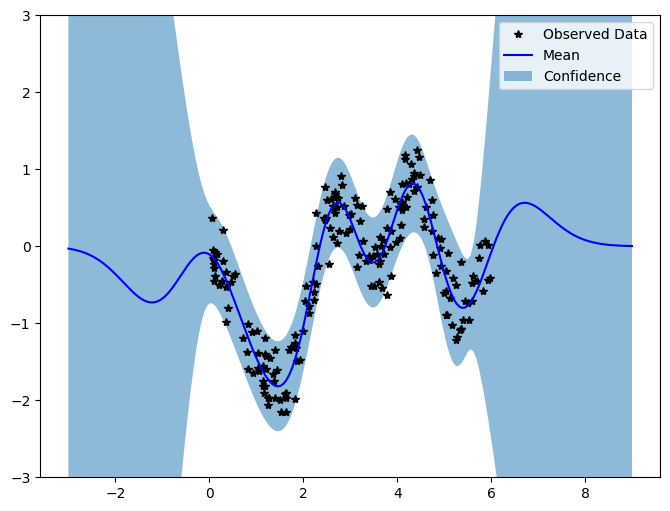

In [127]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

# We randomly choose M points from the training data

M = 10
N = x_train_snelson.shape[ 0 ]
random_points = x_train_snelson[ torch.randperm(x_train_snelson.shape[0])[0:M]]

model_nystrom = NystromSparseGPModel(x_train_snelson, y_train_snelson, random_points, likelihood)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_nystrom)

result = train_model(model_nystrom, mll, x_train_snelson, y_train_snelson)
plot_pred_dist_model(model_nystrom, likelihood)


## **Task 3**
Try runing the previous cell again to see the variability of the approximate predictive distribution when choosing different sets of random points to approximate the covariance matrix.


## **Sparse GPs via Random Features**

In this section we will use the random features approximation of the covariance matrix to speed-up GPs. This approximation is already included in gpytorch and we will only have to use the corresponding kernel.


 Instead of the shifted cosine features from Rahimi and Recht (2008), in gpytorch we use  the sine and cosine features which is a lower-variance estimator --- see    'On the Error of Random Fourier Features' by Sutherland and Schneider (2015).

By Bochner's theorem, any continuous kernel :math:`k` is positive definite
if and only if it is the Fourier transform of a non-negative measure $p(\omega)$, i.e.

$$
            k(x, x') = k(x - x') = \int p(\omega) e^{i(\omega^\top (x - x'))} d\omega.
        $$

where $p(\omega)$ is a normalized probability measure if $k(0)=1$.

For the RBF kernel,
$$
        k(\Delta) = \exp{(-\frac{\Delta^2}{2\sigma^2})}
$$
and
$$p(\omega) = \exp{(-\frac{\sigma^2\omega^2}{2})}$$

where $\Delta = x - x'$.

Given datapoint $x\in \mathbb{R}^d$, we can construct its random Fourier features $z(x) \in \mathbb{R}^{2D}$ by

  $$
        z(x) = \sqrt{\frac{1}{D}}
        \begin{bmatrix}
            \cos(\omega_1^\top x)\\
            \sin(\omega_1^\top x)\\
            \cdots \\
            \cos(\omega_D^\top x)\\
            \sin(\omega_D^\top x)
        \end{bmatrix}, \omega_1, \ldots, \omega_D \sim p(\omega)
      $$

such that we have an unbiased Monte Carlo estimator

 $$
            k(x, x') = k(x - x') \approx z(x)^\top z(x') = \frac{1}{D}\sum_{i=1}^D \cos(\omega_i^\top (x - x')).
   $$



In [128]:
# We define our approximate GP method based on the Random Features approximation

class RFSparseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, num_samples, likelihood):

        # We call the superclass with the training data and the associated likelihood.

        super(RFSparseGPModel, self).__init__(train_x, train_y, likelihood)

        # We consdier a constant mean equal to zero, which the typical case.

        self.mean_module = gpytorch.means.ZeroMean()

        # We consider a squared exponential (RBF) kernel with an amplitude (scale) parameter.
        # We use the kernel RRFKernel provided in Gpytorch. This kernel will compute
        # approximate covariances using random features.

        self.covar_module = gpytorch.kernels.RFFKernel(num_samples = num_samples)


    def forward(self, x):

        # The forwward method simply computes the prior means and covariances of the
        # process values associated to the input data.

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # We return a multivariate Gaussian distribution with the corresponding mean
        # and covariances.

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

That is it! We are now ready to use the previos object for regression with a faster computational cost than the exact GP method. We test its training time on the first dataset.

In [129]:
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

M = 50

model = RFSparseGPModel(train_x, train_y, M, likelihood)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

start = time.time()
result = train_model(model, mll, train_x, train_y)
end = time.time()

print("Total training time:", end - start)

Iter 1/10 - Loss: 77.855923
Iter 2/10 - Loss: -169.036954
Iter 3/10 - Loss: -169.080219
Iter 4/10 - Loss: -169.080219
Iter 5/10 - Loss: -169.080219
Iter 6/10 - Loss: -169.080219
Iter 7/10 - Loss: -169.080219
Iter 8/10 - Loss: -169.080219
Iter 9/10 - Loss: -169.080219
Iter 10/10 - Loss: -169.080219
Total training time: 0.2570812702178955


The training time should be much smaller than the standard full GP for M << N.

### **Predictive Distribution Visualization**

We use the dataset of Ed Snelson for the FITC approximation to check how the approximate predictive distribution looks like and how it compares to the exact one of the full GP.

<Axes: >

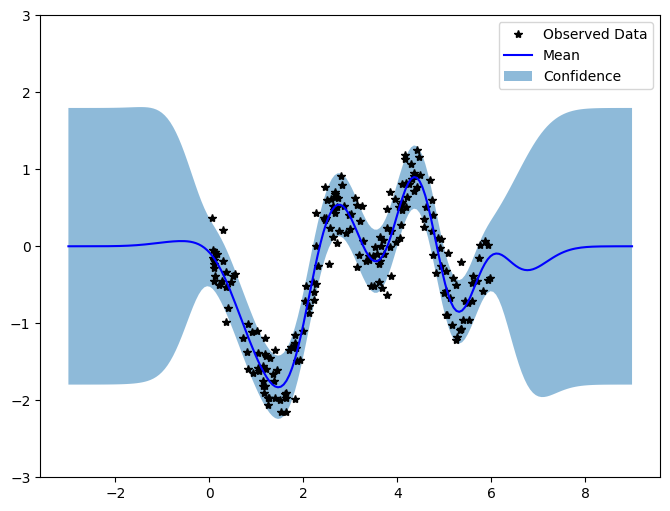

In [130]:
# First, the exact GP again.

plot_pred_dist_model(model_exact, model_exact.likelihood)


Now the RFSparse GP.

Iter 1/10 - Loss: 68.441562
Iter 2/10 - Loss: 55.272914
Iter 3/10 - Loss: 55.207345
Iter 4/10 - Loss: 55.207345
Iter 5/10 - Loss: 55.207345
Iter 6/10 - Loss: 55.207345
Iter 7/10 - Loss: 55.207345
Iter 8/10 - Loss: 55.207345
Iter 9/10 - Loss: 55.207345
Iter 10/10 - Loss: 55.207345


<Axes: >

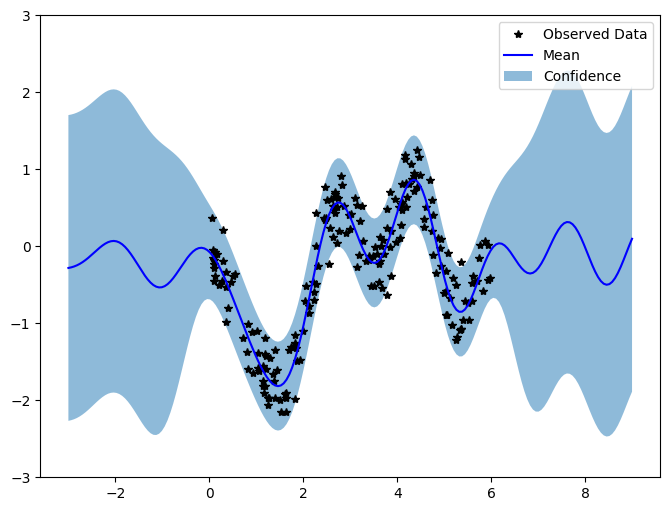

In [131]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

# We randomly choose M points from the training data

M = 50

model_rf = RFSparseGPModel(x_train_snelson, y_train_snelson, M, likelihood)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_rf)

result = train_model(model_rf, mll, x_train_snelson, y_train_snelson)
plot_pred_dist_model(model_rf, likelihood)

As you can see, it is possible to observe the wigglying effect that this approximation has on the approximate predictive distribution.

## **Task 4**

Try changing the value of M in the previous cell, i.e., the number of random features generated. You should observe that the approximate predictive distribution becomes closer and closer for larger and larger values of M. Try using M = 10, 50, 100, 200, 500, 1000, etc.

## **Sparse GPs via the FITC Approximation**


The FITC approximation of the covariance matrix to speed-up the computations of GPs is not directly implemented in GPytorch. However, it is very easy to extend the model to consider it. With this goal, we create a specific covariance function that will do the computations as indicated in the FITC approximation.

In [132]:
# Custom covairance function to implement the FITC approximation.
# This covariance function is equal to InducingPointKernel, but without
# adding extra regularization terms (Eq. 9 of Titsias 2009) to the MLL.

from gpytorch.lazy import LowRankRootAddedDiagLazyTensor, DiagLazyTensor

class FITCKernel(gpytorch.kernels.InducingPointKernel):

    def forward(self, x1, x2, diag=False, **kwargs):
      covar = self._get_covariance(x1, x2)

      if self.training:
        if not torch.equal(x1, x2):
                raise RuntimeError("x1 should equal x2 in training mode")

      if diag:
        return covar.diagonal(dim1=-1, dim2=-2)
      else:
        return covar

    def _get_covariance(self, x1, x2):

        covar = super(FITCKernel, self)._get_covariance(x1, x2)

        # We add diagonal correction if needed (only needed in training)
        # In test it is already added.

        if self.training == True and torch.equal(x1, x2):
            correction = (self.base_kernel(x1, x2, diag=True) - covar.diag()).clamp(0, math.inf)
            return LowRankRootAddedDiagLazyTensor(covar, DiagLazyTensor(correction))

        return covar


The previous kernel implementes the Nyström approximation to the covariances. Recall from what we have seen in the lectures that it is:
$$\Sigma = \Delta + \Sigma_{N,M}\Sigma_{M,M}^{-1}\Sigma_{N,M}$$, where $\Delta = diag(\Sigma) - diag(\Sigma_{N,M}\Sigma_{M,M}^{-1}\Sigma_{N,M})$.
Now, we can define our model. A standard GP using that particular covariance function.

In [133]:
# We define our approximate GP method based on the FITC approximation

class FITCSparseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, initial_inducing_points, likelihood):

        # We call the superclass with the training data and the associated likelihood.

        super(FITCSparseGPModel, self).__init__(train_x, train_y, likelihood)

        # We consdier a constant mean equal to zero, which the typical case.

        self.mean_module = gpytorch.means.ZeroMean()

        # We consider a squared exponential (RBF) kernel with an amplitude (scale) parameter.
        # We use the kernel InducingPointKernel provided in Gpytorch. This kernel will compute
        # approximate covariances as in the Nystrom approximation.

        self.covar_module = FITCKernel(\
              gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()), \
              initial_inducing_points, likelihood)


    def forward(self, x):

        # We add the diagonal correction of the FITC approximation

        gpytorch.settings.sgpr_diagonal_correction(True)

        # The forwward method simply computes the prior means and covariances of the
        # process values associated to the input data.

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # We return a multivariate Gaussian distribution with the corresponding mean
        # and covariances.

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

That is it! We are now ready to use the previos object for regression with a faster computational cost than the exact GP method. We test it on the first dataset considered and measure traning time. In this case, the inducing points will be optimized.

In [134]:
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

# We randomly choose M points from the training data as the inducing points

M = 100
inducing_points = train_x[ torch.randperm(N)[0:M]]

model = FITCSparseGPModel(train_x, train_y, inducing_points, likelihood)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

start = time.time()
result = train_model(model, mll, train_x, train_y)
end = time.time()

print("Total training time:", end - start)

Iter 1/10 - Loss: 346.465449
Iter 2/10 - Loss: -151.961624
Iter 3/10 - Loss: -171.307218
Iter 4/10 - Loss: -171.805723
Iter 5/10 - Loss: -171.837065
Iter 6/10 - Loss: -171.857695
Iter 7/10 - Loss: -171.866990
Iter 8/10 - Loss: -171.886306
Iter 9/10 - Loss: -171.922088
Iter 10/10 - Loss: -171.932731
Total training time: 1.1094551086425781


The traning time should be much smaller than that of the full GP for $M <<N$.

### **Predictive Distribution Visualization**

We use the dataset of Ed Snelson for the FITC approximation to check how the approximate predictive distribution looks like and how it compares to the exact one of the full GP.

<Axes: >

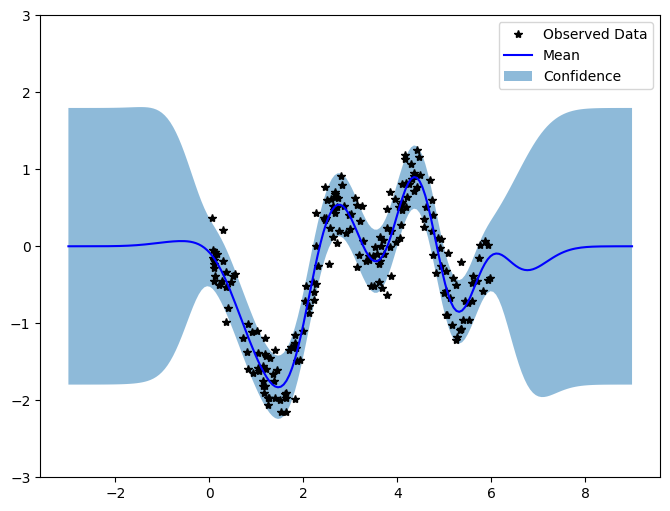

In [135]:
# First, the exact GP again.

plot_pred_dist_model(model_exact, model_exact.likelihood)

Now the FITC sparse GP.

Iter 1/25 - Loss: 73.884456
Iter 2/25 - Loss: 59.483960
Iter 3/25 - Loss: 54.428372
Iter 4/25 - Loss: 53.893085
Iter 5/25 - Loss: 53.652490
Iter 6/25 - Loss: 53.233334
Iter 7/25 - Loss: 52.382074
Iter 8/25 - Loss: 51.672976
Iter 9/25 - Loss: 51.505040
Iter 10/25 - Loss: 51.457080
Iter 11/25 - Loss: 51.219934
Iter 12/25 - Loss: 51.130502
Iter 13/25 - Loss: 51.096281
Iter 14/25 - Loss: 51.070837
Iter 15/25 - Loss: 51.064921
Iter 16/25 - Loss: 51.061468
Iter 17/25 - Loss: 51.060733
Iter 18/25 - Loss: 51.060653
Iter 19/25 - Loss: 51.060537
Iter 20/25 - Loss: 51.060503
Iter 21/25 - Loss: 51.060485
Iter 22/25 - Loss: 51.060485
Iter 23/25 - Loss: 51.060485
Iter 24/25 - Loss: 51.060485
Iter 25/25 - Loss: 51.060485


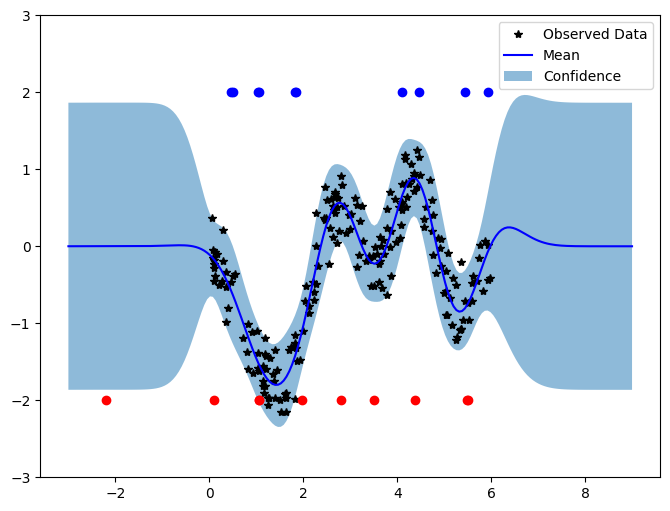

In [136]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

# We randomly choose M points from the training data

M = 10
inducing_points = x_train_snelson[ torch.randperm(x_train_snelson.shape[ 0 ])[0:M]]
#inducing_points = torch.linspace(1, 2, M)
initial_inducing_points = torch.ones(inducing_points.shape) * inducing_points

model_fitc = FITCSparseGPModel(x_train_snelson, y_train_snelson, inducing_points, likelihood)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_fitc)

result = train_model(model_fitc, mll, x_train_snelson, y_train_snelson, training_iter = 25)

ax = plot_pred_dist_model(model_fitc, likelihood)

# We plot the iniital inducing points on top in blue and at the
# optimized inducing points at the bottom in red.

with torch.no_grad():
  ax.plot(initial_inducing_points, torch.ones(M).numpy() * 2, "bo")
  ax.plot(model_fitc.covar_module.inducing_points, torch.ones(M).numpy() * -2, "ro")


## **Task 5**

Try to choose and adversarial initialization of the induicng points and see how they are spread over the input space after optimization. For example, you can place the inducing points un the interval [1,2]. Use torch.linspace(1,2,M) for that.

## **Sparse GPs via the VFE approach**

In this section we try to use in practice the sparse GP approximation based on the variational free energy. This approximation is already implemented in gpytorch, so we do not have to introduce extra code at all.

In [137]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy

# We define our approximate GP method based on the VFE approach

class VFESparseGP(ApproximateGP):
    def __init__(self, inducing_points):

        # We use a zero mean and an RBF kernel

        mean_module = gpytorch.means.ZeroMean()
        covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        # We use a cholesky factorization to represent the parameters of the
        # variational approximate distribution q

        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0), mean_init_std=0.0)

        # We initialize the variational distribution

        init_dist = gpytorch.distributions.MultivariateNormal(torch.zeros(inducing_points.size(0)), \
            covar_module(inducing_points) * 1e-5)

        variational_distribution.initialize_variational_distribution(init_dist)

        # We use an unwhitened variational strategy. Whitening is also possible and
        # described later on.

        variational_strategy = UnwhitenedVariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        variational_strategy.variational_params_initialized = torch.tensor(1) # XXX DHL This avoids random initialization

        super(VFESparseGP, self).__init__(variational_strategy)

        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

We can now create the model and the likelihood. To train this model we no longer can use the marginal likelhood. We will have to use the ELBO given by variational inference.

In [138]:
from gpytorch.mlls import VariationalELBO
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

M = 100
inducing_points = train_x[ 0 : M ]
model = VFESparseGP(inducing_points)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

start = time.time()
result_unwhitened = train_model(model, mll, train_x, train_y, 500, likelihood)
end = time.time()

print("Total training time:", end - start)

Iter 1/500 - Loss: 2846.044612
Iter 2/500 - Loss: 1969.843238
Iter 3/500 - Loss: 1954.307747
Iter 4/500 - Loss: 1870.581563
Iter 5/500 - Loss: 1753.622265
Iter 6/500 - Loss: 1670.022964
Iter 7/500 - Loss: 1642.359770
Iter 8/500 - Loss: 1527.185972
Iter 9/500 - Loss: 1409.387294
Iter 10/500 - Loss: 1348.940063
Iter 11/500 - Loss: 1196.973362
Iter 12/500 - Loss: 1126.595062
Iter 13/500 - Loss: 1063.630524
Iter 14/500 - Loss: 1020.349301
Iter 15/500 - Loss: 969.794323
Iter 16/500 - Loss: 943.102161
Iter 17/500 - Loss: 925.803402
Iter 18/500 - Loss: 903.191256
Iter 19/500 - Loss: 876.462870
Iter 20/500 - Loss: 855.727652
Iter 21/500 - Loss: 832.780462
Iter 22/500 - Loss: 812.512895
Iter 23/500 - Loss: 802.507031
Iter 24/500 - Loss: 789.346645
Iter 25/500 - Loss: 773.079973
Iter 26/500 - Loss: 758.817963
Iter 27/500 - Loss: 750.925288
Iter 28/500 - Loss: 744.754046
Iter 29/500 - Loss: 738.862609
Iter 30/500 - Loss: 730.593505
Iter 31/500 - Loss: 717.671346
Iter 32/500 - Loss: 704.029829
Ite

The training time should be faster than that of a full GP for $M << N$. However, due to the strong dependencies of the prior, fitting the variational distribution may take long. Later on, we will see how speed-up this process. Furthermore, note that in the batch_optimization case (i.e., when no mini-batch training is used) it is possible to derive the optimal parameters of $q$, which will speed-up the training process sinificantly. For simplicity, we do not consider that approach here. However, gpytorch also provides support for it.

### **Predictive Distribution**

We use the dataset of Ed Snelson for the VFE approximation to check how the approximate predictive distribution looks like and how it compares to the exact one of the full GP.

<Axes: >

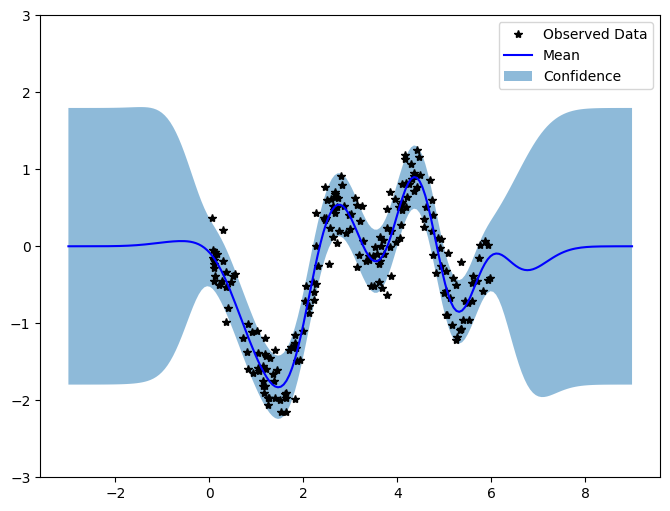

In [139]:
# First, the exact GP again.

plot_pred_dist_model(model_exact, model_exact.likelihood)

Now the VFE Sparse GP.

Iter 1/100 - Loss: 8610.516464
Iter 2/100 - Loss: 3240.031899
Iter 3/100 - Loss: 686.119317
Iter 4/100 - Loss: 324.602911
Iter 5/100 - Loss: 155.021222
Iter 6/100 - Loss: 90.828085
Iter 7/100 - Loss: 77.743553
Iter 8/100 - Loss: 73.153111
Iter 9/100 - Loss: 65.720914
Iter 10/100 - Loss: 64.091284
Iter 11/100 - Loss: 62.462492
Iter 12/100 - Loss: 61.675603
Iter 13/100 - Loss: 61.449223
Iter 14/100 - Loss: 60.929026
Iter 15/100 - Loss: 60.685852
Iter 16/100 - Loss: 60.355138
Iter 17/100 - Loss: 60.024851
Iter 18/100 - Loss: 59.730661
Iter 19/100 - Loss: 59.557651
Iter 20/100 - Loss: 59.438487
Iter 21/100 - Loss: 59.299655
Iter 22/100 - Loss: 59.214661
Iter 23/100 - Loss: 59.095232
Iter 24/100 - Loss: 59.002450
Iter 25/100 - Loss: 58.961996
Iter 26/100 - Loss: 58.931679
Iter 27/100 - Loss: 58.894539
Iter 28/100 - Loss: 58.840982
Iter 29/100 - Loss: 58.819826
Iter 30/100 - Loss: 58.810342
Iter 31/100 - Loss: 58.790852
Iter 32/100 - Loss: 58.771197
Iter 33/100 - Loss: 58.750969
Iter 34/100 

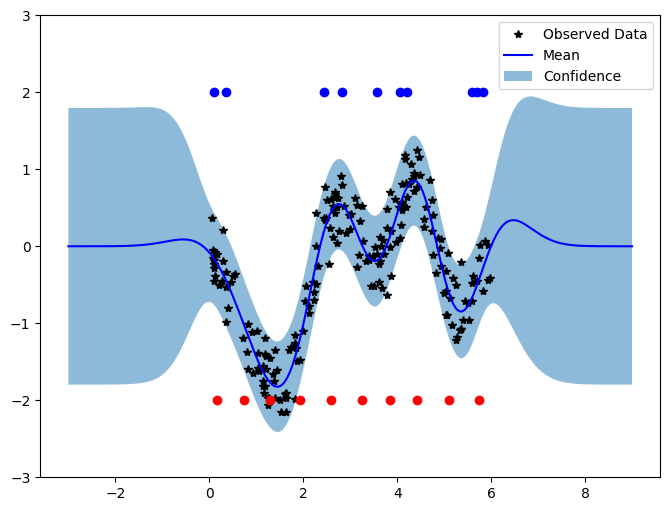

In [140]:
from gpytorch.mlls import VariationalELBO

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.01

# We specify the initial inducing points locations

M = 10
inducing_points = x_train_snelson[ torch.randperm(x_train_snelson.shape[ 0 ])[0:M]]
#inducing_points = torch.linspace(1, 2, M)
initial_inducing_points = torch.ones(inducing_points.shape) * inducing_points

# We create the model and the VFE objective

model_vfe = VFESparseGP(inducing_points)

mll = gpytorch.mlls.VariationalELBO(likelihood, model_vfe, num_data=x_train_snelson.size(0))

# We train the model

result = train_model(model_vfe, mll, x_train_snelson, y_train_snelson, 100, likelihood)

# We plot the predictive distribution

ax = plot_pred_dist_model(model_vfe, likelihood)

# We plot the iniital inducing points on top in blue and at the
# optimized inducing points at the bottom in red.

with torch.no_grad():
  ax.plot(initial_inducing_points, torch.ones(M).numpy() * 2, "bo")
  ax.plot(model_vfe.variational_strategy.inducing_points, torch.ones(M).numpy() * -2, "ro")



## **Task 6**

Try to choose and adversarial initialization of the induicng points and see how they are spread over the input space after optimization. For example, you can place the inducing points un the interval [1,2]. Use torch.linspace(1,2,M) for that.

## **Improving VFE Method by Whitening**

In this section we consdier a whitened approximate distribution $q$ for the VFE method. For that, we simply replace the approximate distribution by UnwhitenedVariationalStrategy by VariationalStrategy.

In [141]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

# We define our approximate GP method based on the VFE approach

class VFESparseGP(ApproximateGP):
    def __init__(self, inducing_points):

        # We use a zero mean and an RBF kernel

        mean_module = gpytorch.means.ZeroMean()
        covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        # We use a cholesky factorization to represent the parameters of the
        # variational approximate distribution q

        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0), mean_init_std=0.0)

        # We initialize the variational distribution

        init_dist = gpytorch.distributions.MultivariateNormal(torch.zeros(inducing_points.size(0)), \
            torch.eye(inducing_points.size(0)) * 1e-5)

        variational_distribution.initialize_variational_distribution(init_dist)

        # We use a whitened variational strategy (default)

        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        variational_strategy.variational_params_initialized = torch.tensor(1) # XXX DHL This avoids random initialization

        super(VFESparseGP, self).__init__(variational_strategy)

        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

We can now create the model and the likelihood. To train this model we no longer can use the marginal likelhood. We will have to use the ELBO given by variational inference.

In [142]:
from gpytorch.mlls import VariationalELBO
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

M = 100
inducing_points = train_x[ 0 : M ]
model = VFESparseGP(inducing_points)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

start = time.time()
result_whitened = train_model(model, mll, train_x, train_y, 500, likelihood)
end = time.time()

print("Total training time:", end - start)

Iter 1/500 - Loss: 3181.769901
Iter 2/500 - Loss: 1247.853363
Iter 3/500 - Loss: 1106.072586
Iter 4/500 - Loss: 1032.233446
Iter 5/500 - Loss: 939.636454
Iter 6/500 - Loss: 864.446519
Iter 7/500 - Loss: 815.350720
Iter 8/500 - Loss: 797.053623
Iter 9/500 - Loss: 781.541154
Iter 10/500 - Loss: 774.223374
Iter 11/500 - Loss: 759.089709
Iter 12/500 - Loss: 743.335485
Iter 13/500 - Loss: 738.036153
Iter 14/500 - Loss: 714.523691
Iter 15/500 - Loss: 699.021752
Iter 16/500 - Loss: 650.259996
Iter 17/500 - Loss: 644.730500
Iter 18/500 - Loss: 618.963421
Iter 19/500 - Loss: 593.701463
Iter 20/500 - Loss: 541.921394
Iter 21/500 - Loss: 496.275946
Iter 22/500 - Loss: 385.692200
Iter 23/500 - Loss: 322.439915
Iter 24/500 - Loss: 272.227537
Iter 25/500 - Loss: 244.264387
Iter 26/500 - Loss: 205.878755
Iter 27/500 - Loss: 190.281956
Iter 28/500 - Loss: 181.427990
Iter 29/500 - Loss: 177.631950
Iter 30/500 - Loss: 170.111377
Iter 31/500 - Loss: 165.394619
Iter 32/500 - Loss: 164.175836
Iter 33/500 -

As you can see using a Whitened Variational Distribution helps in the optimization process. In particular, better values for the objective are obtained with a smaller number of iterations. That is why it is the default variational approximation in gpytorch.

<ipython-input-143-71b7cd63d36f>:3: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(np.arange(0,500)), result_unwhitened.numpy(), 'r')
<ipython-input-143-71b7cd63d36f>:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(np.arange(0,500)), result_whitened.numpy(),'b')


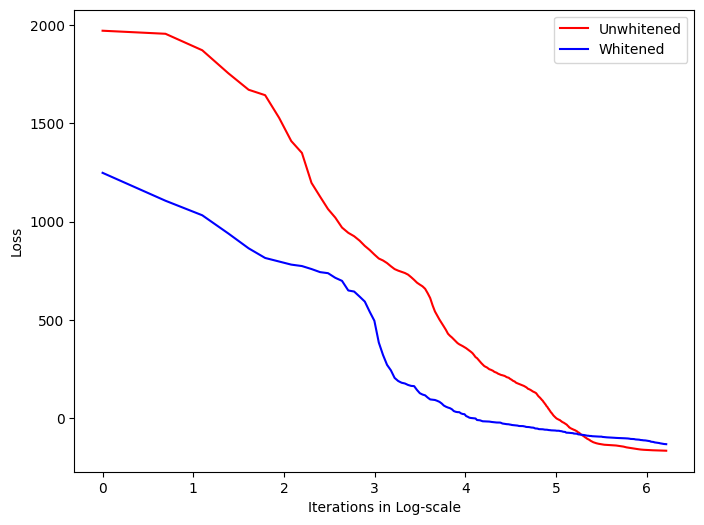

In [143]:
  f, ax = plt.subplots(1, 1, figsize=(8, 6))
  with torch.no_grad():
    ax.plot(np.log(np.arange(0,500)), result_unwhitened.numpy(), 'r')
    ax.plot(np.log(np.arange(0,500)), result_whitened.numpy(),'b')
  ax.set_xlabel("Iterations in Log-scale")
  ax.set_ylabel("Loss")
  ax.legend(['Unwhitened', 'Whitened'])

## **Natural Gradients**

In this section we explore the utility of natural gradients for optimizing the variational distribution. We will use a standard ADAM optimizer instead of L-BFGS to better see the differences in optimization by changing the gradients for $q$. We consider a whitened variational distribution.

First we train the method using ADAM and standard gradients.

In [144]:
def train_model_ADAM(model, mll, train_x, train_y, training_iter = 10, likelihood = None):

  model.train()
  losses = torch.zeros(training_iter)

  # we instantiate the ADAM optimizer, which will optimize the hyper-parameters.

  if likelihood is None:
    parameters = model.parameters()
  else:
    parameters = list(model.parameters()) + list(likelihood.parameters())

  optimizer = torch.optim.Adam(parameters, lr = 0.01)

  def closure():
      optimizer.zero_grad()
      output = model(train_x)
      loss = -mll(output, train_y)
      loss.backward()
      return loss

  for i in range(training_iter):

    loss = closure() * train_x.shape[ 0 ]
    print('Iter %d/%d - Loss: %f' % (i + 1, training_iter, loss.item()))
    losses[ i ] = torch.from_numpy(np.array([loss.item()]))

    optimizer.step(closure)

  return losses

We do now the actual training.

In [145]:
from gpytorch.mlls import VariationalELBO
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

M = 100
inducing_points = train_x[ 0 : M ]
model = VFESparseGP(inducing_points)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

start = time.time()
result_standard_gradients = train_model_ADAM(model, mll, train_x, train_y, 500, likelihood)
end = time.time()

print("Total training time:", end - start)

Iter 1/500 - Loss: 3181.769901
Iter 2/500 - Loss: 2961.808865
Iter 3/500 - Loss: 2786.086569
Iter 4/500 - Loss: 2673.130347
Iter 5/500 - Loss: 2538.401003
Iter 6/500 - Loss: 2413.653458
Iter 7/500 - Loss: 2292.867392
Iter 8/500 - Loss: 2187.860472
Iter 9/500 - Loss: 2088.147654
Iter 10/500 - Loss: 2000.964450
Iter 11/500 - Loss: 1920.920291
Iter 12/500 - Loss: 1848.212561
Iter 13/500 - Loss: 1782.486329
Iter 14/500 - Loss: 1724.297423
Iter 15/500 - Loss: 1671.497601
Iter 16/500 - Loss: 1623.117578
Iter 17/500 - Loss: 1580.443552
Iter 18/500 - Loss: 1542.566819
Iter 19/500 - Loss: 1506.012897
Iter 20/500 - Loss: 1472.556538
Iter 21/500 - Loss: 1441.849091
Iter 22/500 - Loss: 1410.004954
Iter 23/500 - Loss: 1379.136746
Iter 24/500 - Loss: 1348.240916
Iter 25/500 - Loss: 1320.729809
Iter 26/500 - Loss: 1291.892583
Iter 27/500 - Loss: 1265.527080
Iter 28/500 - Loss: 1239.666030
Iter 29/500 - Loss: 1214.546086
Iter 30/500 - Loss: 1190.603651
Iter 31/500 - Loss: 1168.101250
Iter 32/500 - Los

The first step towards using natural gradients is defining a NaturalVariational distribution. Therefore, we have to re-define the model.

In [146]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import NaturalVariationalDistribution
from gpytorch.variational import VariationalStrategy

# We define our approximate GP method based on the VFE approach

class NaturalVFESparseGP(ApproximateGP):
    def __init__(self, inducing_points):

        # We use a zero mean and an RBF kernel

        mean_module = gpytorch.means.ZeroMean()
        covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        # We use a cholesky factorization to represent the parameters of the
        # variational approximate distribution q

        variational_distribution = NaturalVariationalDistribution(inducing_points.size(0), mean_init_std=0.0)

        # We initialize the variational distribution

        init_dist = gpytorch.distributions.MultivariateNormal(torch.zeros(inducing_points.size(0)), \
            torch.eye(inducing_points.size(0)) * 1e-5)

        variational_distribution.initialize_variational_distribution(init_dist)

        # We use a whitened variational strategy.

        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        variational_strategy.variational_params_initialized = torch.tensor(1) # XXX DHL This avoids random initialization

        super(NaturalVFESparseGP, self).__init__(variational_strategy)

        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Now we define a separate optimizer for the parameters related to the variational distribuiton. This optimizer will use natural gradients.

In [147]:
def train_model_NaturalGradients(model, mll, train_x, train_y, training_iter = 10, likelihood = None):

  model.train()
  losses = torch.zeros(training_iter)

  # We instantiate the LBFGS optimizer, which will optimize the hyper-parameters.

  if likelihood is None:
    parameters = model.hyperparameters()
  else:
    parameters = list(model.hyperparameters()) + list(likelihood.parameters())

  optimizer = torch.optim.Adam(parameters, lr = 0.01)

  # We instantiate the NGD optimizer, which will optimize the variational distribution q.
  # This optimizer allows to have larger learning rates.

  variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), \
      num_data=train_y.size(0), lr=1.0)

  def closure():
      optimizer.zero_grad()
      variational_ngd_optimizer.zero_grad()
      output = model(train_x)
      loss = -mll(output, train_y)
      loss.backward()
      return loss

  for i in range(training_iter):

    loss = closure() * train_x.shape[ 0 ]
    print('Iter %d/%d - Loss: %f' % (i + 1, training_iter, loss.item()))
    losses[ i ] = torch.from_numpy(np.array([loss.item()]))

    # We update each parameter group according to each optimizer

    optimizer.step()
    variational_ngd_optimizer.step()

  return losses

We do now the actual training using natural gradients.

In [148]:
from gpytorch.mlls import VariationalELBO
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

M = 100
inducing_points = train_x[ 0 : M ]
model = NaturalVFESparseGP(inducing_points)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

start = time.time()
result_natural_gradients = train_model_NaturalGradients(model, mll, train_x, train_y, 500, likelihood)
end = time.time()

print("Total training time:", end - start)

Iter 1/500 - Loss: 3181.769901
Iter 2/500 - Loss: 5677.468223
Iter 3/500 - Loss: 2396.656152
Iter 4/500 - Loss: 1512.567434
Iter 5/500 - Loss: 822.199934
Iter 6/500 - Loss: 756.382179
Iter 7/500 - Loss: 720.640980
Iter 8/500 - Loss: 694.768818
Iter 9/500 - Loss: 674.778169
Iter 10/500 - Loss: 658.548431
Iter 11/500 - Loss: 644.662118
Iter 12/500 - Loss: 632.386463
Iter 13/500 - Loss: 621.325091
Iter 14/500 - Loss: 611.230648
Iter 15/500 - Loss: 601.929109
Iter 16/500 - Loss: 593.289334
Iter 17/500 - Loss: 585.208957
Iter 18/500 - Loss: 577.606404
Iter 19/500 - Loss: 570.415632
Iter 20/500 - Loss: 563.582311
Iter 21/500 - Loss: 557.060954
Iter 22/500 - Loss: 550.812738
Iter 23/500 - Loss: 544.803879
Iter 24/500 - Loss: 539.004448
Iter 25/500 - Loss: 533.387526
Iter 26/500 - Loss: 527.928601
Iter 27/500 - Loss: 522.605136
Iter 28/500 - Loss: 517.396235
Iter 29/500 - Loss: 512.282375
Iter 30/500 - Loss: 507.245164
Iter 31/500 - Loss: 502.267105
Iter 32/500 - Loss: 497.331367
Iter 33/500 -

We now plot the optimization results of each method.

<ipython-input-149-a2e8989d3035>:3: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(np.arange(0,500)), result_standard_gradients.numpy(), 'r')
<ipython-input-149-a2e8989d3035>:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(np.log(np.arange(0,500)), result_natural_gradients.numpy(),'b')


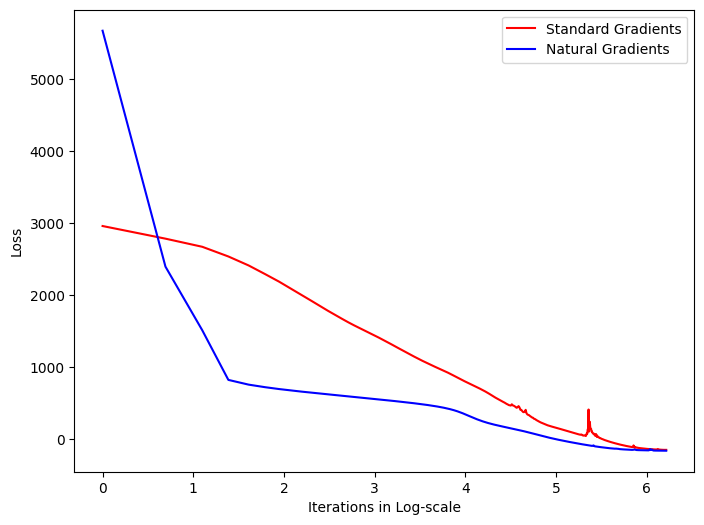

In [149]:
f, ax = plt.subplots(1, 1, figsize=(8, 6))
with torch.no_grad():
    ax.plot(np.log(np.arange(0,500)), result_standard_gradients.numpy(), 'r')
    ax.plot(np.log(np.arange(0,500)), result_natural_gradients.numpy(),'b')
ax.set_xlabel("Iterations in Log-scale")
ax.set_ylabel("Loss")
ax.legend(['Standard Gradients', 'Natural Gradients'])

## **Training Using Mini-batches**

We now show that the VFE method allows for training using mini-batches. This means that we can update the model parameters without having to go through all the data. In this way, the training cost will no longer depende on the number of training instances, assuming a constant number of interations until convergence. To test this, we consider the first toy dataset described in this notebook and report the loss of a batch-method and the loss of a method using mini-batches, as a function of the number of mini-batches processed.


In [150]:
# We consdier 1000 instances

N = 1000

# Training data are N points regularly spaced in the interval [0,1].

train_x = torch.linspace(0, 1, N)

# True function is sin(2*pi*x) with additive Gaussian noise with variance 0.04.

train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

We now define a training method that considers minibatches.

In [151]:
from torch.utils.data import TensorDataset, DataLoader

def train_model_ADAM_mini_batches(model, mll, train_x, train_y, training_iter = 10, \
      batch_size = 100, likelihood = None):

  model.train()
  losses = torch.zeros(training_iter * int(train_x.shape[ 0 ] / batch_size))

  # we instantiate the ADAM optimizer, which will optimize the hyper-parameters.

  if likelihood is None:
    parameters = model.parameters()
  else:
    parameters = list(model.parameters()) + list(likelihood.parameters())

  optimizer = torch.optim.Adam(parameters, lr = 0.01)

  train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=batch_size, shuffle=True)

  def closure(mini_batch_x, mini_batch_y):
      optimizer.zero_grad()
      output = model(mini_batch_x)
      loss = -mll(output, mini_batch_y)
      loss.backward()
      return loss

  # We loop through the number of iterations (epochs)

  for i in range(training_iter):

    # We loop through the mini_batches

    j = 0
    for (x_batch, y_batch) in train_loader:

      loss = closure(x_batch, y_batch) * train_x.shape[ 0 ]
      print('Iter %d/%d - Loss: %f' % (i + 1, training_iter, loss.item()))
      losses[ i * int(train_x.shape[ 0 ] / batch_size) + j ] = torch.from_numpy(np.array([loss.item()]))
      optimizer.step()
      j += 1

  return losses

We train the method using mini-batches for a total of 100 iterations through the data. That is, 100 epochs.

In [152]:
from gpytorch.mlls import VariationalELBO
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

M = 100
inducing_points = train_x[ 0 : M ]
model = VFESparseGP(inducing_points)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

num_epochs = 100
mini_batch_size = 100

start = time.time()
result_mini_batches = train_model_ADAM_mini_batches(model, mll, train_x, train_y, num_epochs, mini_batch_size, likelihood)
end = time.time()

print("Total training time:", end - start)

Iter 1/100 - Loss: 3441.637689
Iter 1/100 - Loss: 3043.851850
Iter 1/100 - Loss: 2906.593113
Iter 1/100 - Loss: 2575.987178
Iter 1/100 - Loss: 2421.756879
Iter 1/100 - Loss: 2581.389340
Iter 1/100 - Loss: 2255.028868
Iter 1/100 - Loss: 2413.455948
Iter 1/100 - Loss: 1898.609789
Iter 1/100 - Loss: 1884.394406
Iter 2/100 - Loss: 2060.419479
Iter 2/100 - Loss: 2069.977095
Iter 2/100 - Loss: 1743.569098
Iter 2/100 - Loss: 2005.899378
Iter 2/100 - Loss: 1720.588544
Iter 2/100 - Loss: 1506.890994
Iter 2/100 - Loss: 1616.005482
Iter 2/100 - Loss: 1483.756160
Iter 2/100 - Loss: 1539.991183
Iter 2/100 - Loss: 1543.939547
Iter 3/100 - Loss: 1338.328351
Iter 3/100 - Loss: 1304.660811
Iter 3/100 - Loss: 1458.632736
Iter 3/100 - Loss: 1403.270856
Iter 3/100 - Loss: 1536.958966
Iter 3/100 - Loss: 1474.315846
Iter 3/100 - Loss: 1129.958563
Iter 3/100 - Loss: 1327.437178
Iter 3/100 - Loss: 1429.110108
Iter 3/100 - Loss: 1223.292547
Iter 4/100 - Loss: 1103.526568
Iter 4/100 - Loss: 1304.410548
Iter 4/1

We train the method using all data for a total of 100 iterations.

In [153]:
from gpytorch.mlls import VariationalELBO
import time

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

M = 100
inducing_points = train_x[ 0 : M ]
model = VFESparseGP(inducing_points)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x.size(0))

num_epochs = 100

start = time.time()
result_all_data = train_model_ADAM_mini_batches(model, mll, train_x, train_y, num_epochs, train_x.shape[ 0 ], likelihood)
end = time.time()

print("Total training time:", end - start)

Iter 1/100 - Loss: 3225.760506
Iter 2/100 - Loss: 3003.626578
Iter 3/100 - Loss: 2826.350914
Iter 4/100 - Loss: 2712.602398
Iter 5/100 - Loss: 2579.577060
Iter 6/100 - Loss: 2447.230147
Iter 7/100 - Loss: 2327.543832
Iter 8/100 - Loss: 2218.900580
Iter 9/100 - Loss: 2117.587751
Iter 10/100 - Loss: 2028.846600
Iter 11/100 - Loss: 1945.872979
Iter 12/100 - Loss: 1871.620742
Iter 13/100 - Loss: 1803.839764
Iter 14/100 - Loss: 1742.477845
Iter 15/100 - Loss: 1689.430831
Iter 16/100 - Loss: 1636.819269
Iter 17/100 - Loss: 1594.749572
Iter 18/100 - Loss: 1555.488707
Iter 19/100 - Loss: 1517.331505
Iter 20/100 - Loss: 1484.294557
Iter 21/100 - Loss: 1453.899750
Iter 22/100 - Loss: 1422.302945
Iter 23/100 - Loss: 1389.939867
Iter 24/100 - Loss: 1360.407170
Iter 25/100 - Loss: 1331.778315
Iter 26/100 - Loss: 1304.002620
Iter 27/100 - Loss: 1276.127290
Iter 28/100 - Loss: 1250.468079
Iter 29/100 - Loss: 1224.755903
Iter 30/100 - Loss: 1201.033484
Iter 31/100 - Loss: 1178.056957
Iter 32/100 - Los

We plot the performance of each method as a function of the number of instances processed.

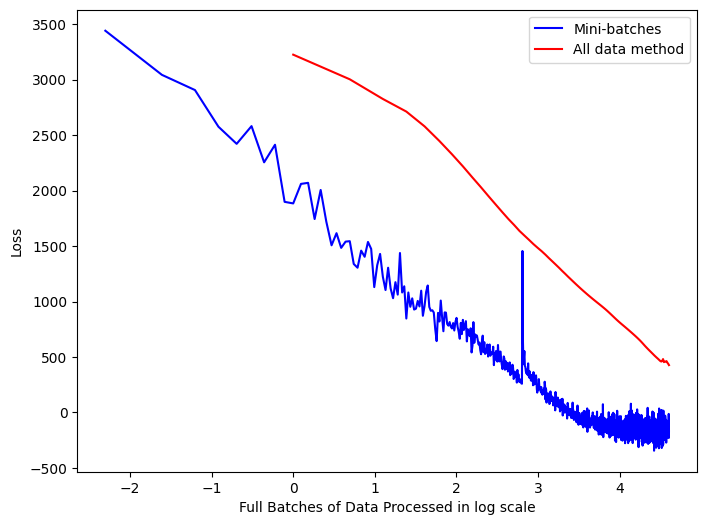

In [154]:
input_all_data = ((np.arange(0, result_all_data.shape[ 0 ]) + 1) * train_x.shape[ 0 ]) / train_x.shape[ 0 ]
input_mini_batches = (np.arange(0, result_mini_batches.shape[0]) + 1)* mini_batch_size / train_x.shape[ 0 ]

f, ax = plt.subplots(1, 1, figsize=(8, 6))
with torch.no_grad():
    ax.plot(np.log(input_mini_batches), result_mini_batches.numpy(), 'b')
    ax.plot(np.log(input_all_data), result_all_data.numpy(),'r')
ax.set_xlabel("Full Batches of Data Processed in log scale")
ax.set_ylabel("Loss")
ax.legend(['Mini-batches', 'All data method'])

## **VFE Sparse GP for Classification**

In this part of the notebook we illustrate how to use the sparse VFE GP to address classification problems. In this case, the likelihood that we will use the CDF of the standard Gaussian distribution as the activation function. The required expectation of the data-dependent terms of the ELBO, e.g., $E_q[\log p(y_i|f(x_i))]$, are intractable, but they are approximated in gpytorch by quadrature.

We generate first some synthetic data in a two dimensional space. The problem considered is the XOR problem, which is non-linear.

In [155]:
# We generate random data uniformly in the unit box with a fixed random seed.

n_train = 200

torch.random.manual_seed(0)

x1 = torch.rand(n_train, 1) - 0.5
x2 = torch.rand(n_train,1) - 0.5

# We define the target function which generates the class label.

data_fn = lambda x1, x2: (torch.sign(torch.sign(x1) * torch.sign(x2)) + 1.0) * 0.5

# We generate the observed data.

latent_fn = data_fn(x1, x2)
train_y_c = torch.round(latent_fn).long().squeeze()
train_x_c = torch.cat((x1, x2),dim=1)
color = np.array(["red", "blue"])[ train_y_c.numpy() ]
train_y_c = train_y_c.float()

We now plot the data for visualization.

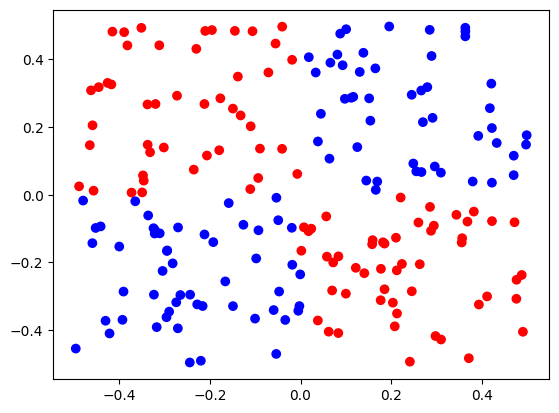

In [156]:
plt.scatter(train_x_c[:,0].numpy(), train_x_c[:,1].numpy(), c = color)


We are now ready to define the GP method.

In [157]:
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

# We choose the inducing points

M = 10
inducing_points = train_x_c[ 0 : M, : ]
#ind_x1 = torch.rand(M, 1) * 0.2 + 0.5
#ind_x2 = torch.rand(M, 1) * 0.2 + 0.5
#inducing_points = torch.cat((ind_x1, ind_x2),dim=1)


initial_inducing_points = torch.ones(inducing_points.shape) * inducing_points

# We create the model and the objective

model = VFESparseGP(inducing_points)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_x_c.size(0))

# We train the model

start = time.time()
result_natural_gradients = train_model(model, mll, train_x_c, train_y_c, 500, likelihood)
end = time.time()

print("Total training time:", end - start)

Iter 1/500 - Loss: 191.313345
Iter 2/500 - Loss: 146.602035
Iter 3/500 - Loss: 109.244244
Iter 4/500 - Loss: 96.183835
Iter 5/500 - Loss: 93.292673
Iter 6/500 - Loss: 89.385539
Iter 7/500 - Loss: 88.693572
Iter 8/500 - Loss: 88.149180
Iter 9/500 - Loss: 87.264130
Iter 10/500 - Loss: 87.134690
Iter 11/500 - Loss: 85.649539
Iter 12/500 - Loss: 83.477357
Iter 13/500 - Loss: 76.711937
Iter 14/500 - Loss: 72.967513
Iter 15/500 - Loss: 70.173731
Iter 16/500 - Loss: 67.915847
Iter 17/500 - Loss: 65.532498
Iter 18/500 - Loss: 64.527234
Iter 19/500 - Loss: 62.549835
Iter 20/500 - Loss: 62.084243
Iter 21/500 - Loss: 61.848086
Iter 22/500 - Loss: 61.183649
Iter 23/500 - Loss: 60.046245
Iter 24/500 - Loss: 59.755342
Iter 25/500 - Loss: 59.029657
Iter 26/500 - Loss: 58.328383
Iter 27/500 - Loss: 57.283924
Iter 28/500 - Loss: 57.103870
Iter 29/500 - Loss: 56.621205
Iter 30/500 - Loss: 55.786598
Iter 31/500 - Loss: 54.707131
Iter 32/500 - Loss: 53.882955
Iter 33/500 - Loss: 53.613480
Iter 34/500 - Lo

First, we generate the test data.

In [158]:
x1_test = torch.linspace(-1, 1, 20)
x2_test = torch.linspace(-1, 1, 20)
test_x_c = torch.cartesian_prod(x1_test, x2_test)

We obtain the class posterior probabilities after training.

In [159]:
with torch.no_grad():
  latent_process_values = model(test_x_c)

class_probs = likelihood(latent_process_values).mean

We compute now the test error to see what is the generalization performance of the previous classifier.

In [160]:
test_labels = data_fn(test_x_c[:,0:1], test_x_c[:,1:2])
test_error = torch.mean(((class_probs > 0.5).type(torch.DoubleTensor) \
    != test_labels[:,0]).type(torch.DoubleTensor))
print('Test error: %.3f' % test_error)

Test error: 0.018


We plot the predictive distribution. That is the estimated class posterior probability for each potential label. Initial inducing points appear in pink. Final inducing pints appear in green.


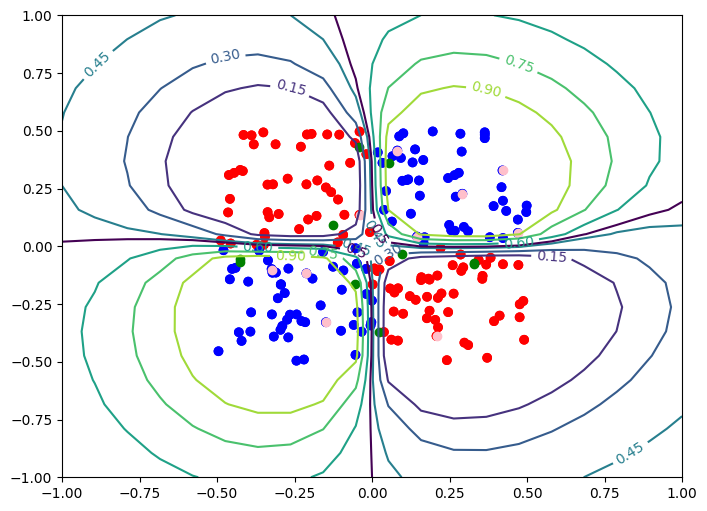

In [161]:
final_inducing_points = model.variational_strategy.inducing_points

fig, ax = plt.subplots(figsize = (8, 6))
CS = ax.contour(x1_test.numpy(), x2_test.numpy(), class_probs.numpy().reshape((20,20)))
ax.clabel(CS, inline=True, fontsize=10)
CS = ax.contour(x1_test.numpy(), x2_test.numpy(), class_probs.numpy().reshape((20,20)), levels = [0.5])
ax.clabel(CS, inline=True, fontsize=10)
plt.scatter(train_x_c[:,0].numpy(), train_x_c[:,1].numpy(), c = color)
plt.scatter(train_x_c[:,0].numpy(), train_x_c[:,1].numpy(), c = color)
plt.scatter(initial_inducing_points[:,0].numpy(), initial_inducing_points[:,1].numpy(), c = "pink")
with torch.no_grad():
  plt.scatter(final_inducing_points[:,0].numpy(), final_inducing_points[:,1].numpy(), c = "green")

We observe that the inducing points tend to concentrate near the decision boundaries.

## **Task 7**

Intialize the inducing points in the previous problem in an adversial way. For that, uncomment the code below the generation of the initial inducing points. Train the model again and see how the inducing points spread across the input space.